Il faut garder toutes les données selon la prof, on retirera uniquement les BPM impossibles (vu que le reste on a pas les connaissances)

# IMPORTATION DES PACKAGES

In [136]:
import pandas as pd
from sklearn import tree
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
# from sklearn.cluster import HDBSCAN
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix, silhouette_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
# from sklearn.preprocessing import StandardScaler
#from sklearn.inspection import DecisionBoundaryDisplay
import warnings
#from imblearn.over_sampling import RandomOverSampler
warnings.filterwarnings("ignore")
import numpy as np
import shap


# Description et visualisation du jeu de données

In [131]:
# les fonctions definitives pour eviter de faire cellule par cellule
def description(file):
    data = pd.read_csv(file)
    print("le jeu de données contient ",data.shape[0]," lignes et ", data.shape[1]," colonnes\n")
    print("les 10 premières du jeu de données :\n")
    print(data.head())
    print("les différents types de données:\n")
    print(data.info())
    print("la description des données de type numériques:\n")
    print(data.describe())
    print("la distribution des observations en fonction de la variable cible:\n")
    print(round(data["Result"].value_counts(normalize=True),2))
    print("la répartition homme femme:\n")
    print(round(data["Gender"].value_counts(normalize=True),2))
    
    return(data)
    

def visualisation (data, Y, title):
    # print("la distribution des observations en fonction de la variable cible:\n")
    round(data["Result"].value_counts(normalize=True),2)
    sns.countplot(x=Y, data=data)
    plt.xlabel('Les 2 types de résultats')
    plt.ylabel('Nombre d\'occurrences')
    plt.title(title)
    plt.show()
    
    data.dtypes.value_counts().plot.pie()
    plt.show()
    
    sns.scatterplot(data=data, x="Systolic blood pressure", y="Age", hue=data["Result"])
    plt.title("Scatter plot of systolic pressure by age")
    plt.show()
    
    #sns.pairplot(data)
    #plt.show()
    for col in data.select_dtypes(['int','float']):
        plt.figure
        sns.boxplot(data[col])
        plt.title(col)
        plt.show()
    
def split(data,size,class_label):
    train_set, test_set = train_test_split(data, train_size=size, random_state=0, stratify=class_label)
    return train_set, test_set


def split_2(train_set, test_set):
    y_test = test_set["Result"]
    y_train = train_set["Result"]
    # encoder = preprocessing.LabelEncoder()
    # Y_encd = encoder.fit_transform(Y)
    #x_train = train_set.iloc[:, 0:8]
    x_train = train_set.drop("Result", axis=1)
    #x_test = test_set.iloc[:, 0:8]
    x_test = test_set.drop("Result", axis=1)
    return x_train, x_test, y_train, y_test


def preprocess(data):
    data_clean = data.copy()
    for col in data_clean.select_dtypes(['int','float']).columns:
        Q1 = data_clean[col].quantile(0.25)
        Q3 = data_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        # print(IQR, Q1-1.5*IQR, Q3+1.5*IQR)
        data_clean = data_clean[~((data_clean[col]<(Q1-1.5*IQR))|(data_clean[col]>(Q3+1.5*IQR)))]
    
    # encodage des variables 
    # variable target   
    label = preprocessing.LabelEncoder()
    data_clean['Result'] = label.fit_transform(data_clean['Result'])
    # variable binaire
    #binary = preprocessing.LabelBinarizer()
    #data_clean['Gender'] = binary.fit_transform(data_clean['Gender'])
    #scaler = StandardScaler()
    #data_clean["Heart rate"] = scaler.fit_transform(data_clean[col])
    
    return(data_clean)

def deco(x):
    print(str(x)*100)
    

le jeu de données contient  1319  lignes et  9  colonnes

les 10 premières du jeu de données :

   Age  Gender  Heart rate  Systolic blood pressure  Diastolic blood pressure  \
0   64       1          66                      160                        83   
1   21       1          94                       98                        46   
2   55       1          64                      160                        77   
3   64       1          70                      120                        55   
4   55       1          64                      112                        65   

   Blood sugar  CK-MB  Troponin    Result  
0        160.0   1.80     0.012  negative  
1        296.0   6.75     1.060  positive  
2        270.0   1.99     0.003  negative  
3        270.0  13.87     0.122  positive  
4        300.0   1.08     0.003  negative  
les différents types de données:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 9 columns):
 #   Column  

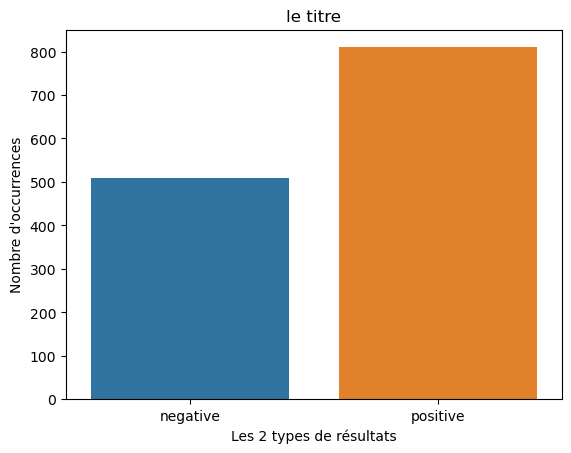

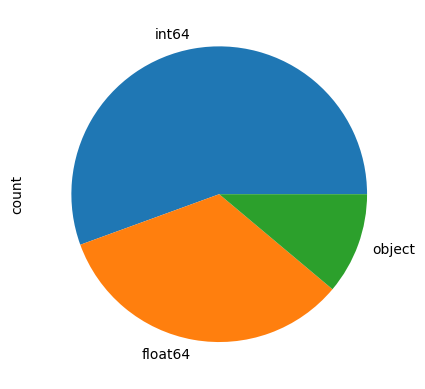

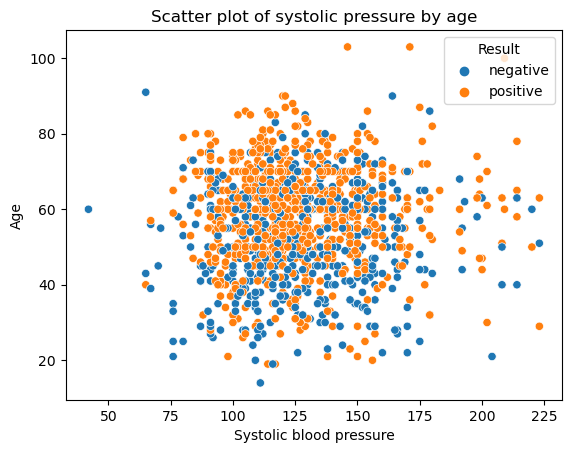

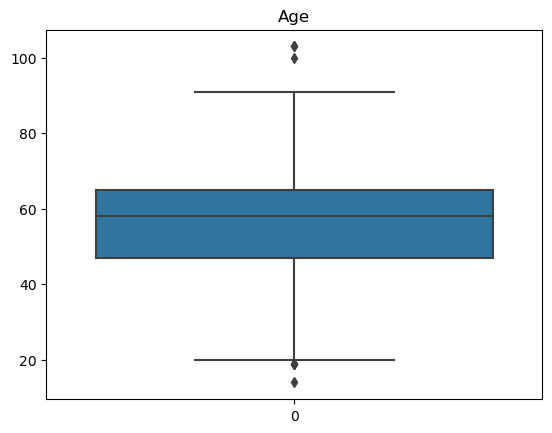

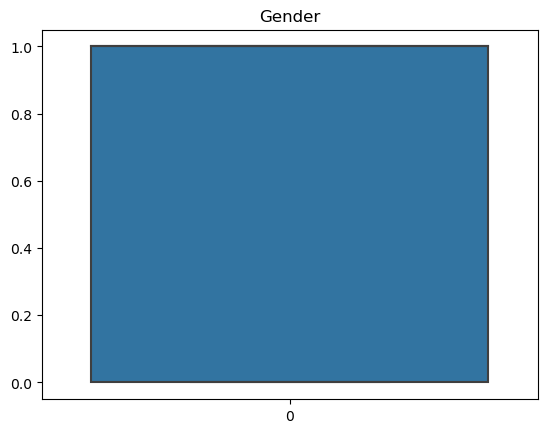

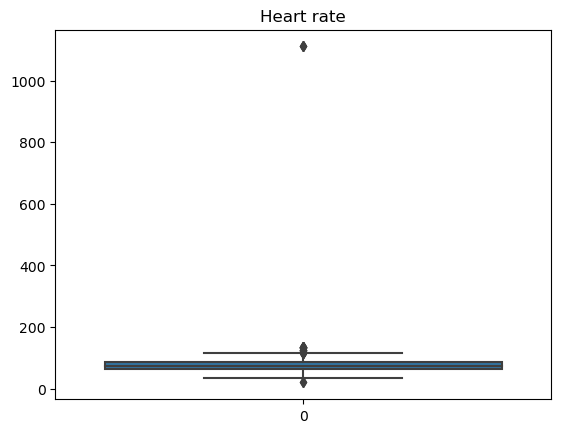

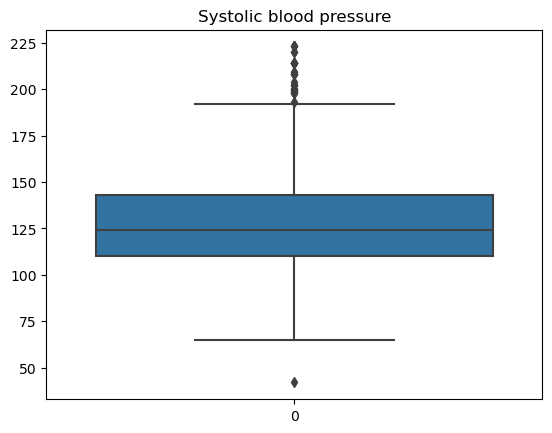

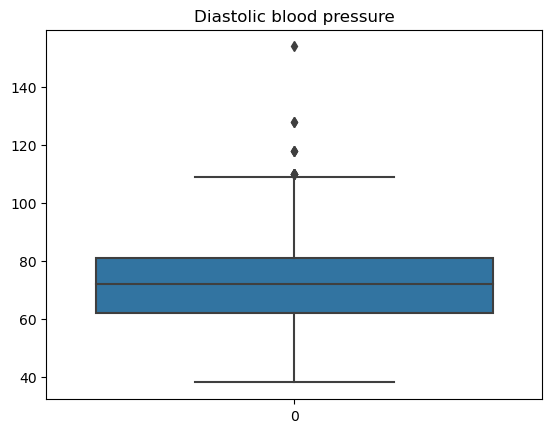

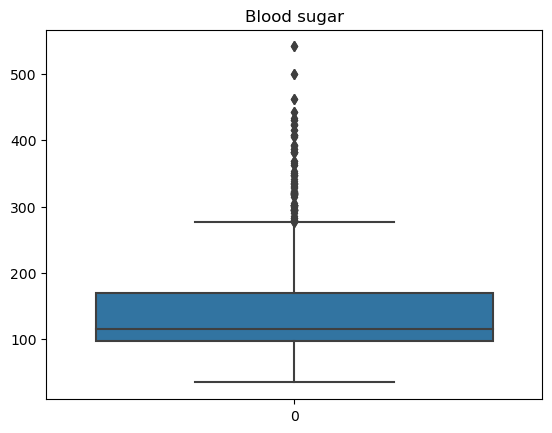

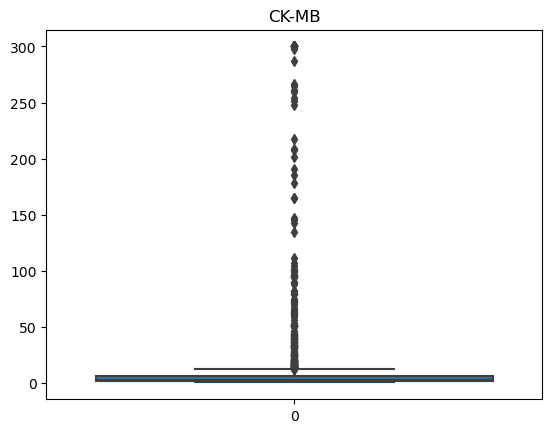

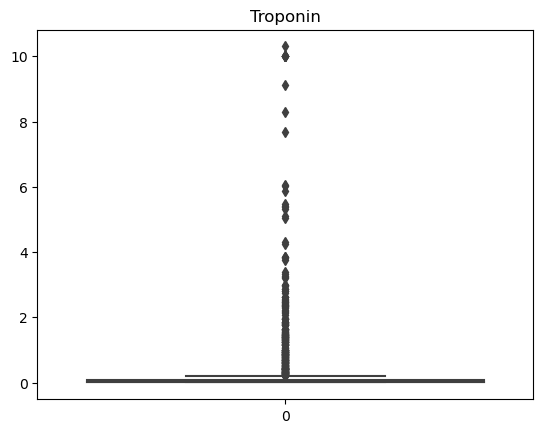

la distribution des classes dans le train set :
 Result
0    0.57
1    0.43
Name: proportion, dtype: float64
____________________________________________________________________________________________________
la distribution des classes dans le test set :
 Result
0    0.56
1    0.44
Name: proportion, dtype: float64


In [132]:
# Description
data=description("Medicaldataset.csv")
visualisation(data, data["Result"],"le titre")

# Prepocessing
data_clean = preprocess(data)

data_clean.head()

#Train test split
train_set, test_set = split(data_clean, 0.8, data_clean["Result"])
# visualisation
print("la distribution des classes dans le train set :\n", round(train_set['Result'].value_counts(normalize=True),2))
deco("_")
print("la distribution des classes dans le test set :\n", round(test_set['Result'].value_counts(normalize=True),2))

x_train, x_test, y_train, y_test = split_2(train_set, test_set)


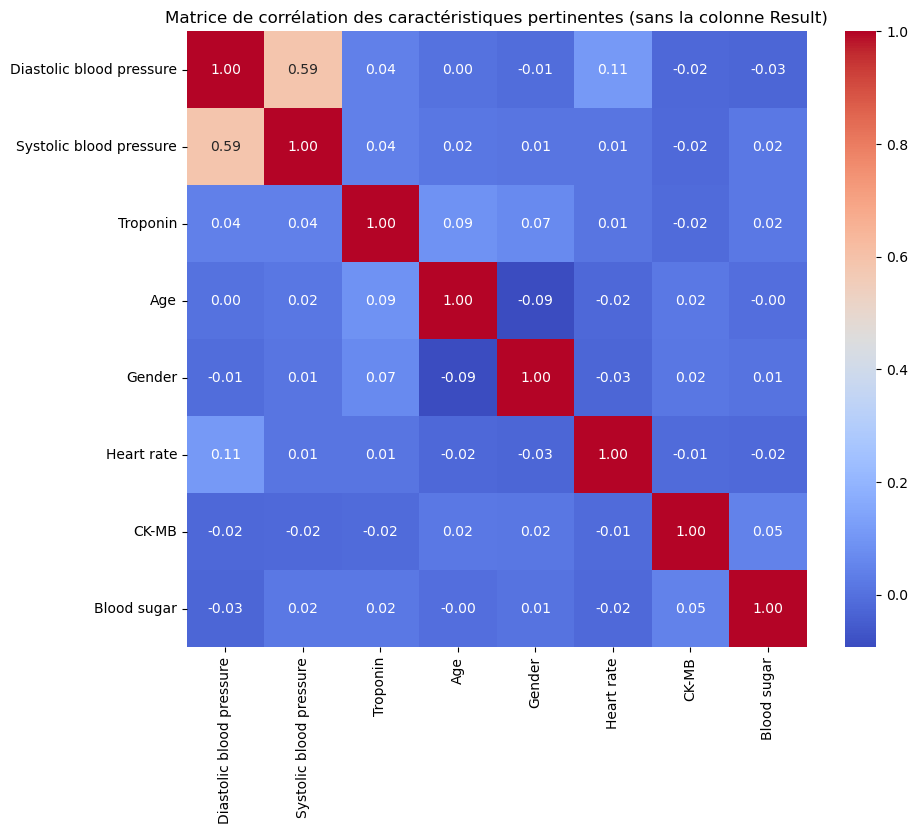

In [88]:
df_features_only = data.drop(columns=['Result'])

# Calculer la matrice de corrélation
correlation_matrix = df_features_only.corr()

# Filtrer les caractéristiques ayant une corrélation significative entre elles
relevant_features = correlation_matrix.abs().sum(axis=1).sort_values(ascending=False).index[:8]
df_subset = data[relevant_features]
plt.figure(figsize=(10, 8))
sns.heatmap(df_subset.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de corrélation des caractéristiques pertinentes (sans la colonne Result)')
plt.show()

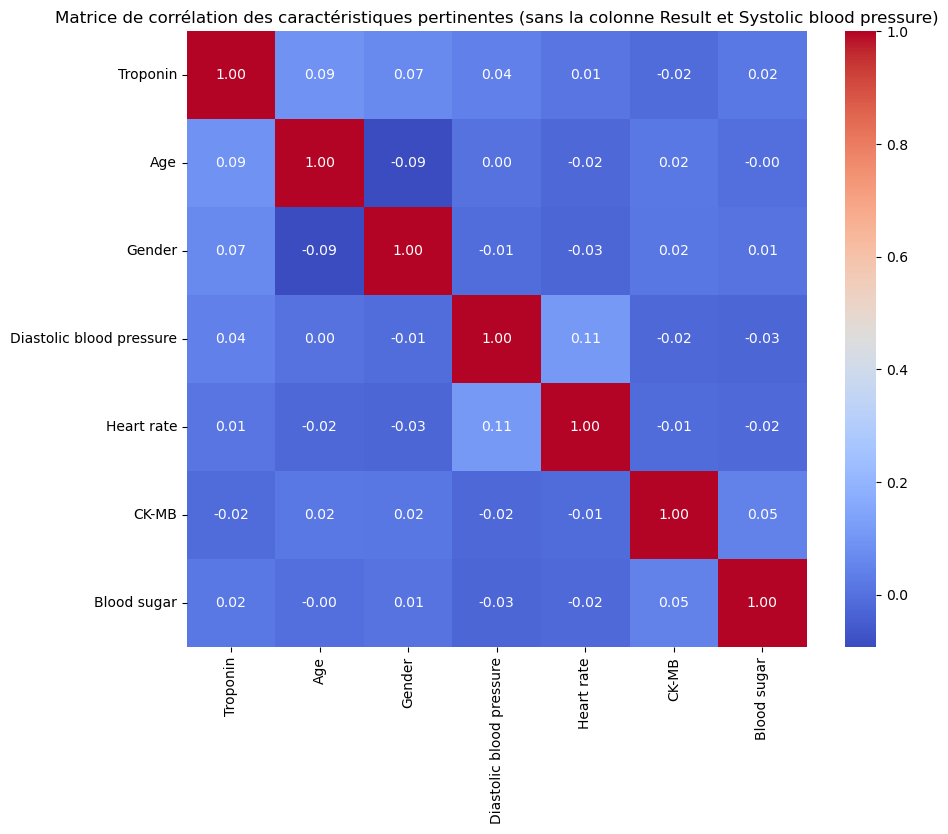

In [109]:
df_features_only = data.drop(columns=['Result','Systolic blood pressure'])

# Calculer la matrice de corrélation
correlation_matrix = df_features_only.corr()

# Filtrer les caractéristiques ayant une corrélation significative entre elles
relevant_features = correlation_matrix.abs().sum(axis=1).sort_values(ascending=False).index[:8]
df_subset = data[relevant_features]
plt.figure(figsize=(10, 8))
sns.heatmap(df_subset.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de corrélation des caractéristiques pertinentes (sans la colonne Result et Systolic blood pressure)')
plt.show()

### Preprocessing 2

Formule pour calculer la FCM (fréquence cardiaque maximale) :  
Homme : ```FCM = 220 - votre âge```  
Femme : ```FCM = 226 - votre âge```  
Source : <a href="https://www.decathloncoach.com/fr/home/advices/advice/frequence-cardiaque-reserve-repos-et-maximale">Décathlon coach</a>

Autre formule pour calculer sa FCM (fréquence cardiaque maximale) :  
```FCM = 207 – 0,7 x âge```  
Source : <a href="https://www.irbms.com/calculer-sa-frequence-cardiaque-pour-un-effort/">IRBMS</a>

In [110]:
def preprocess2(data):
    print(data.shape)
    x_data_2 = data.drop(columns = ['Systolic blood pressure'])
    #Calculer si les BPM sont possibles
    x_data_2['BPM_possible'] = False
    x_data_2.loc[x_data_2['Heart rate']<= 207 - (0.7*x_data_2['Age']), 'BPM_possible'] = True
    x_data_2.loc[x_data_2['BPM_possible'] == False]
    data2 = x_data_2.loc[x_data_2['BPM_possible']==True]
    print(data2.shape)
    
    label = preprocessing.LabelEncoder()
    data2['Result'] = label.fit_transform(data2['Result'])
    # variable binaire
    #binary = preprocessing.LabelBinarizer()
    #data2['Gender'] = binary.fit_transform(data2['Gender'])
    
    
    return(data2.drop('BPM_possible',axis=1))

In [111]:
data_clean2 = preprocess2(data)
data_clean2.head()

(1319, 9)
(1316, 9)


,Age,Gender,Heart rate,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
0,64,1,66,83,160.0,1.80,0.012,0
1,21,1,94,46,296.0,6.75,1.060,1
2,55,1,64,77,270.0,1.99,0.003,0
3,64,1,70,55,270.0,13.87,0.122,1
4,55,1,64,65,300.0,1.08,0.003,0


In [112]:
#Train test split
train_set2, test_set2 = split(data_clean2, 0.8, data_clean2["Result"])
# visualisation
print("la distribution des classes dans le train set 2 :\n", round(train_set2['Result'].value_counts(normalize=True),2))
deco("_")
print("la distribution des classes dans le test set 2 :\n", round(test_set2['Result'].value_counts(normalize=True),2))

x_train2, x_test2, y_train2, y_test2 = split_2(train_set2, test_set2)

la distribution des classes dans le train set 2 :
 Result
1    0.61
0    0.39
Name: proportion, dtype: float64
____________________________________________________________________________________________________
la distribution des classes dans le test set 2 :
 Result
1    0.61
0    0.39
Name: proportion, dtype: float64


## Correlation matrix here

# Application des modèles superivisés

In [133]:
def implemantation_supervise(model, x_train, y_train, x_test, n_neighbors=3):
    # if model == KNeighborsClassifier:
    # MD = model(n_neighbors)
    # else:
    MD = model
    mdl = MD.fit(x_train, y_train)


    if str(model) == "SVC()":
        X = x_train.iloc[:, [0, 5]]  # ON COMMENCE À 0
        print(X)

        md = svm.SVC()
        model = md.fit(X, y_train)

        # print(pd.DataFrame(X).columns[0])
        X0, X1 = X.iloc[:, 0], X.iloc[:, 1]

        # Titre du graphique
        title = "SVC with linear kernel"

        # Affichage de la séparation des classes dans l'espace des caractéristiques
        fig, ax = plt.subplots()
        disp = DecisionBoundaryDisplay.from_estimator(
            md,
            X,
            response_method="predict",
            ax=ax,
            xlabel=pd.DataFrame(data_clean).columns[0],
            ylabel=pd.DataFrame(data_clean).columns[5],
        )
        ax.scatter(X0, X1, c=y_train, s=20, edgecolors="k")
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(title)

        plt.show()

    if str(model) == "GaussianNB()":
        # Calculer les probabilités a priori
        prior_probs = model.class_prior_

        # Calculer les probabilités postérieures pour chaque classe
        posterior_probs = model.predict_proba(x_test)
        print(type(posterior_probs))
        print(prior_probs.mean(axis=0))

        # Plot
        classes = ["negatif", "positif"]
        n_classes = 2
        # len(classes)

        # Plot des probabilités a priori
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.bar(classes, prior_probs)
        plt.title('Probabilités a priori')
        plt.xlabel('Classe')
        plt.ylabel('Probabilité')

        # Plot des probabilités postérieures pour une seule instance de test
        instance_index = 0
        plt.subplot(1, 2, 2)
        plt.bar(classes, posterior_probs.mean(axis=0))
        plt.title('Probabilités postérieures pour une instance de test')
        plt.xlabel('Classe')
        plt.ylabel('Probabilité')

        plt.tight_layout()
        plt.show()

    if str(model) == "DecisionTreeClassifier()" or str(model)== "RandomForestClassifier()":
        explainer = shap.TreeExplainer(mdl)
        shap_values = explainer.shap_values(x_test)
        shap.summary_plot(shap_values, x_test, title=str(MD))

        explainer = shap.TreeExplainer(mdl)
        shap_values = explainer.shap_values(x_test)
        shap.summary_plot(shap_values[1], x_test.values, feature_names=x_test.columns, title=str(MD))

    y_pred = mdl.predict(x_test)

    if str(model) == "DecisionTreeClassifier()":
        tree.plot_tree(MD,
                  feature_names=['Age', 'Gender', 'Heart rate','Systolic blood pressure', 'Diastolic blood pressure', 'Blood sugar', 'CK-MB',
                                 'Troponin'],
                  class_names=["Positive", "Negative"], filled=True)
        #plt.savefig('ARBRE.png', bbox_inches='tight')
        #plt.savefig('ARBRE.pdf', bbox_inches='tight')

        plt.show()

    print("IMPLEMENTATION DE", MD)
    return y_pred


def scoring(y_pred, y_test):
    accuracy = metrics.accuracy_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    print("l'accuracy :\n", round(accuracy,4))
    deco("_")
    print("le f1 score:\n", round(f1,4))
    deco("_")
    print("la matrice de confusion\n")
    cf_matrix = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(cf_matrix, display_labels=[False, True])
    cm_display.plot()
    plt.show()
    deco("_")
    print(classification_report(y_test, y_pred))
    deco("_")
    return (accuracy, f1, recall)


In [53]:
mdl_sup = [DecisionTreeClassifier(), RandomForestClassifier(),AdaBoostClassifier(), svm.SVC(),KNeighborsClassifier(),GaussianNB()]
# LinearSVC(),


## avec la première fonction de preprocessing

IMPLEMENTATION DE DecisionTreeClassifier()


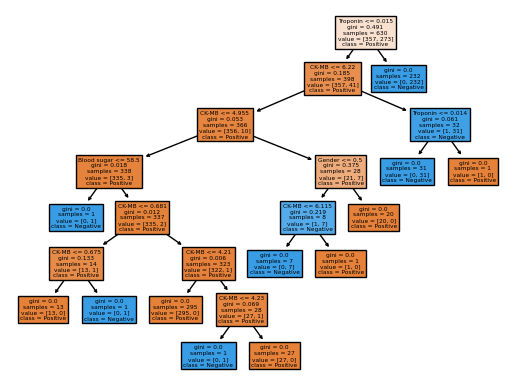

l'accuracy :
 0.981
____________________________________________________________________________________________________
le f1 score:
 0.9787
____________________________________________________________________________________________________
la matrice de confusion



<Figure size 640x480 with 0 Axes>

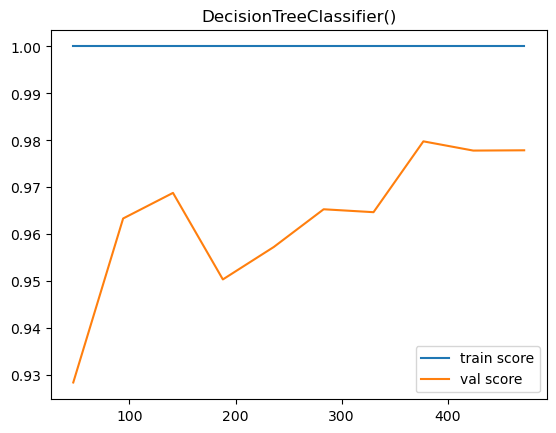

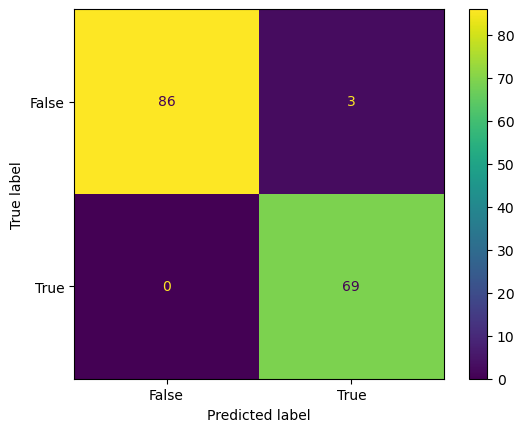

____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        89
           1       0.96      1.00      0.98        69

    accuracy                           0.98       158
   macro avg       0.98      0.98      0.98       158
weighted avg       0.98      0.98      0.98       158

____________________________________________________________________________________________________
IMPLEMENTATION DE RandomForestClassifier()
l'accuracy :
 0.981
____________________________________________________________________________________________________
le f1 score:
 0.9784
____________________________________________________________________________________________________
la matrice de confusion



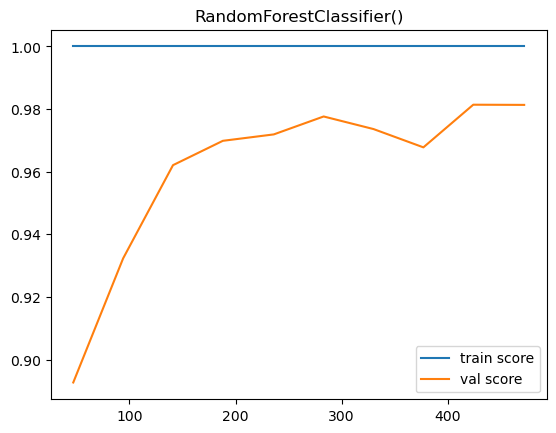

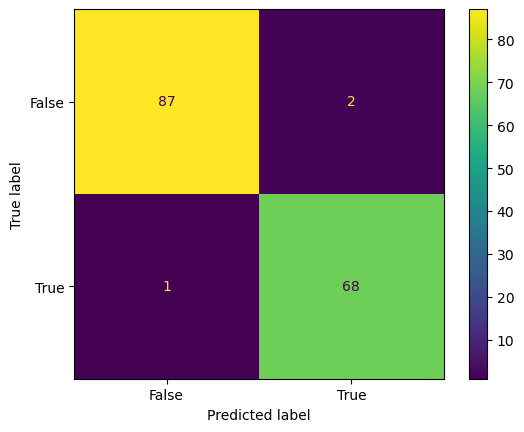

____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.99      0.98      0.98        89
           1       0.97      0.99      0.98        69

    accuracy                           0.98       158
   macro avg       0.98      0.98      0.98       158
weighted avg       0.98      0.98      0.98       158

____________________________________________________________________________________________________
IMPLEMENTATION DE AdaBoostClassifier()
l'accuracy :
 0.981
____________________________________________________________________________________________________
le f1 score:
 0.9784
____________________________________________________________________________________________________
la matrice de confusion



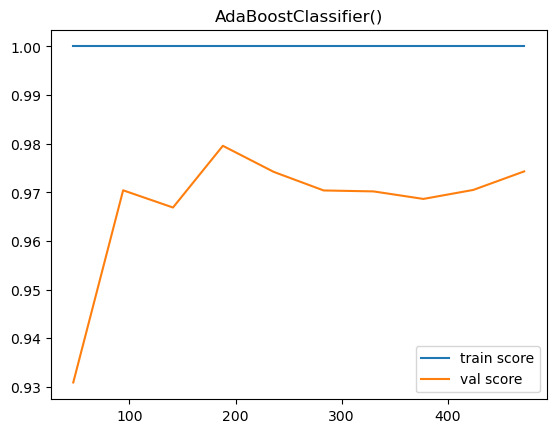

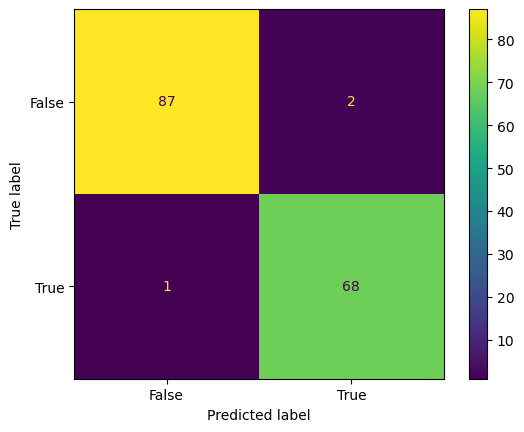

____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.99      0.98      0.98        89
           1       0.97      0.99      0.98        69

    accuracy                           0.98       158
   macro avg       0.98      0.98      0.98       158
weighted avg       0.98      0.98      0.98       158

____________________________________________________________________________________________________
IMPLEMENTATION DE SVC()
l'accuracy :
 0.6646
____________________________________________________________________________________________________
le f1 score:
 0.5225
____________________________________________________________________________________________________
la matrice de confusion



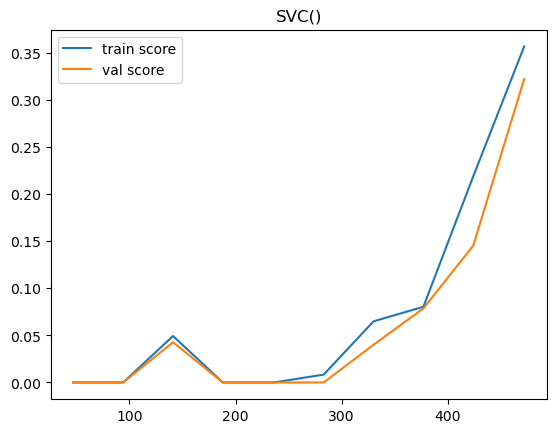

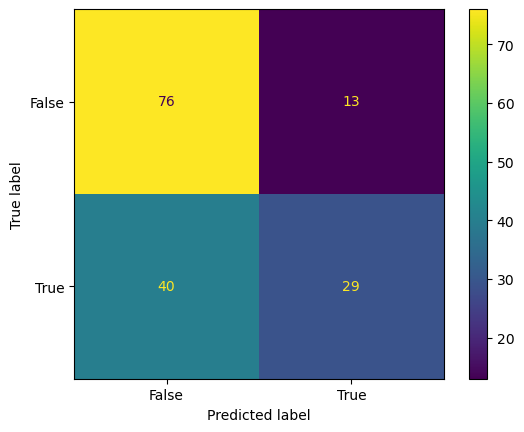

____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.66      0.85      0.74        89
           1       0.69      0.42      0.52        69

    accuracy                           0.66       158
   macro avg       0.67      0.64      0.63       158
weighted avg       0.67      0.66      0.65       158

____________________________________________________________________________________________________
IMPLEMENTATION DE KNeighborsClassifier()
l'accuracy :
 0.5949
____________________________________________________________________________________________________
le f1 score:
 0.5152
____________________________________________________________________________________________________
la matrice de confusion



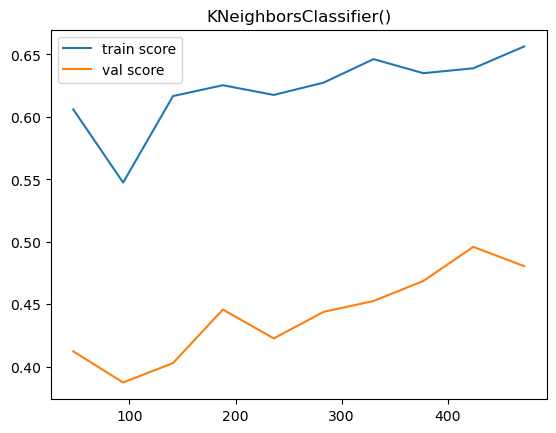

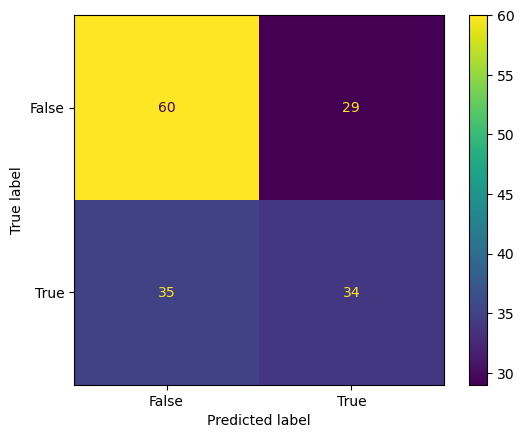

____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.63      0.67      0.65        89
           1       0.54      0.49      0.52        69

    accuracy                           0.59       158
   macro avg       0.59      0.58      0.58       158
weighted avg       0.59      0.59      0.59       158

____________________________________________________________________________________________________
IMPLEMENTATION DE GaussianNB()


ValueError: Expected 2D array, got 1D array instead:
array=[62. 74. 53. 59. 45. 52. 70. 45. 61. 60. 62. 28. 32. 70. 55. 87. 57. 71.
 48. 74. 72. 41. 60. 53. 64. 55. 64. 63. 27. 60. 60. 58. 45. 68. 77. 63.
 43. 60. 63. 49. 65. 54. 43. 74. 54. 65. 75. 63. 52. 21. 33. 55. 74. 75.
 54. 67. 67. 42. 25. 67. 40. 63. 73. 52. 68. 66. 63. 86. 58. 75. 73. 63.
 40. 33. 65. 65. 53. 36. 68. 85. 25. 34. 22. 38. 55. 37. 61. 79. 52. 57.
 66. 45. 40. 57. 60. 64. 39. 70. 55. 55. 44. 46. 48. 21. 44. 54. 51. 63.
 72. 47. 67. 65. 29. 70. 27. 65. 60. 54. 64. 70. 41. 45. 49. 63. 56. 33.
 65. 67. 42. 35. 50. 63. 48. 79. 45. 34. 37. 43. 35. 68. 50. 75. 45. 37.
 65. 55. 62. 43. 63. 60. 56. 62. 37. 54. 75. 51. 77. 53. 58. 62. 53. 72.
 61. 60. 36. 56. 44. 47. 26. 73. 33. 45. 55. 57. 47. 31. 61. 50. 54. 80.
 83. 47. 71. 68. 48. 55. 32. 60. 64. 52. 36. 74. 68. 54. 33. 65. 75. 72.
 55. 29. 39. 52. 68. 55. 73. 43. 69. 53. 43. 70. 70. 48. 68. 45. 24. 68.
 60. 54. 55. 73. 67. 44. 43. 53. 49. 60. 40. 70. 44. 78. 50. 63. 60. 38.
 25. 63. 72. 57. 50. 41. 66. 49. 54. 38. 73. 75. 40. 63. 44. 27. 40. 56.
 75. 47. 62. 23. 45. 75. 69. 39. 41. 50. 63. 37. 75. 60. 33. 60. 70. 67.
 55. 74. 58. 48. 75. 57. 82. 27. 60. 60. 71. 77. 68. 49. 67. 49. 67. 60.
 60. 60. 47. 52. 65. 60. 65. 75. 52. 60. 49. 60. 29. 32. 62. 55. 50. 60.
 50. 51. 54. 51. 48. 30. 27. 44. 60. 56. 75. 61. 39. 57. 47. 49. 41. 42.
 45. 91. 60. 75. 53. 34. 45. 45. 50. 79. 42. 69. 48. 68. 58. 83. 63. 60.
 48. 53. 58. 45. 45. 42. 59. 68. 75. 72. 74. 63. 60. 50. 65. 81. 70. 52.
 44. 60. 70. 70. 60. 42. 45. 53. 38. 41. 64. 77. 66. 55. 58. 50. 60. 53.
 61. 66. 70. 70. 41. 60. 40. 50. 50. 62. 70. 60. 66. 63. 63. 60. 50. 32.
 56. 73. 70. 80. 53. 70. 70. 54. 36. 38. 38. 63. 59. 50. 40. 46. 60. 40.
 68. 66. 54. 38. 63. 51. 67. 71. 70. 38. 58. 55. 45. 52. 55. 28. 38. 47.
 56. 70. 50. 42. 35. 65. 75. 48. 33. 61. 32. 56. 80. 75. 47. 46. 70. 70.
 70. 71. 76. 39. 42. 56. 55. 73. 75. 56. 80. 42. 78. 37. 50. 63. 63. 39.
 71. 50. 43. 45. 34. 51. 51. 51. 44. 50. 45. 75. 58. 49. 35. 70. 73. 65.
 71. 60. 43. 77. 63. 60. 47. 52. 37. 40. 47. 50. 43. 85. 73. 56. 44. 70.
 67. 24. 42. 77. 72. 50. 52. 34. 53. 53. 43. 37. 30. 61. 66. 60. 31. 63.
 72. 62. 63. 65. 60. 65. 70. 64. 56. 75. 52. 48. 49. 55. 60. 66. 73. 40.
 40. 60. 56. 68. 66. 78. 44. 68. 45. 60. 58. 71. 55. 64. 57. 29. 63. 62.
 50. 63. 43. 52. 51. 75. 60. 61. 32. 42. 69. 66. 55. 50. 53. 65. 55. 66.
 29. 60. 68. 65. 52. 90. 48. 35. 65. 67. 54. 35. 60. 73. 72. 60. 70. 40.
 58. 68. 53. 62. 50. 58. 45. 71. 32. 78. 45. 55. 72. 28. 35. 51. 70. 36.
 44. 56. 45. 65. 52. 80. 46. 22. 50. 35. 70. 78. 22. 63. 62. 57. 70. 46.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [126]:
acc_sup = []
f1_sup = []
recall_sup = []

for m in mdl_sup:
    y_pred = implemantation_supervise(m, x_train, y_train, x_test)
    acc, f1,recall = scoring(y_pred, y_test)
    acc_sup.append(acc)
    f1_sup.append(f1)
    recall_sup.append(recall)
    

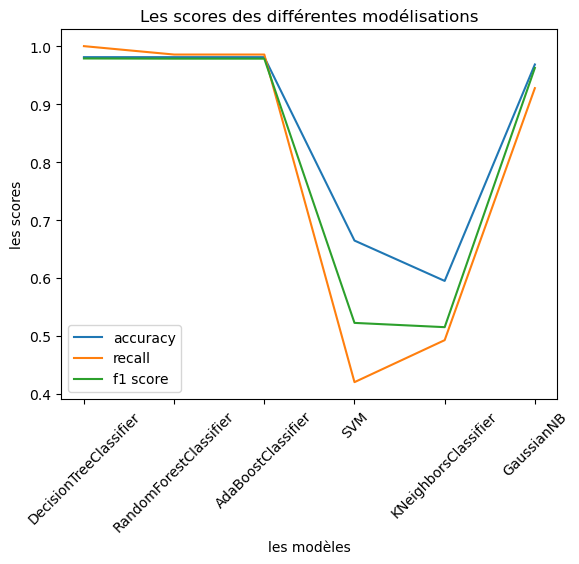

In [115]:
#Afficher la liste des scores dans une courbe
#print(score_list)
mdl_ls = ["DecisionTreeClassifier", "RandomForestClassifier","AdaBoostClassifier", "SVM","KNeighborsClassifier","GaussianNB"]
# "LinearSVC",
fig, ax = plt.subplots()
ax.set(title="Les scores des différentes modélisations",
           ylabel="les scores",
          xlabel="les modèles")
ax.set_xticklabels(mdl_ls, rotation =45)
ax.plot(mdl_ls,acc_sup, label="accuracy")
ax.plot(mdl_ls,recall_sup, label="recall")
ax.plot(mdl_ls,f1_sup, label="f1 score")
plt.legend()

## avec la deuxième fonction de preprocessing

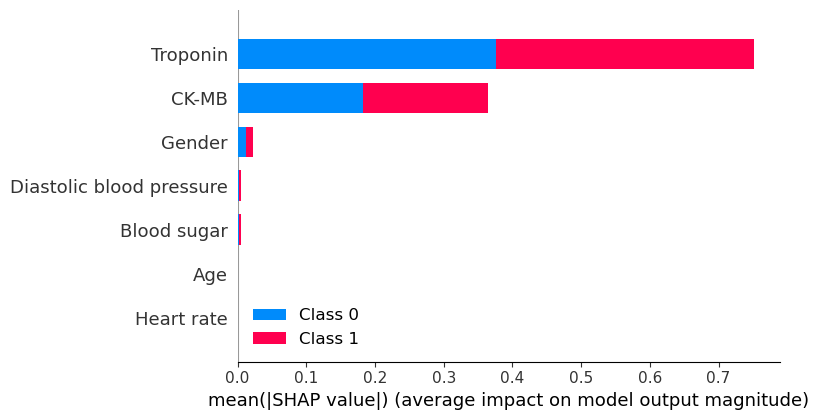

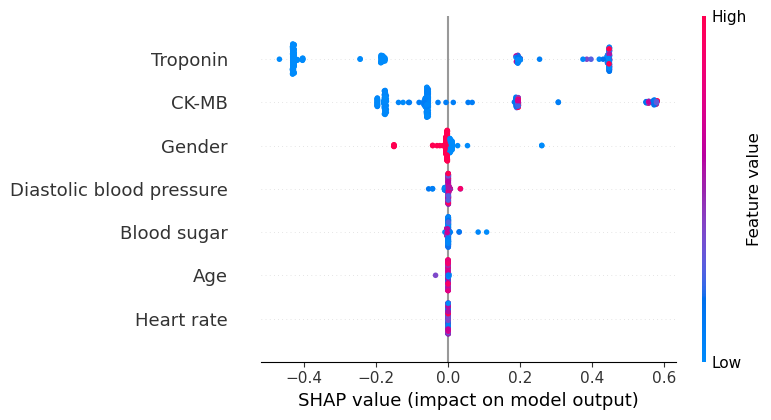

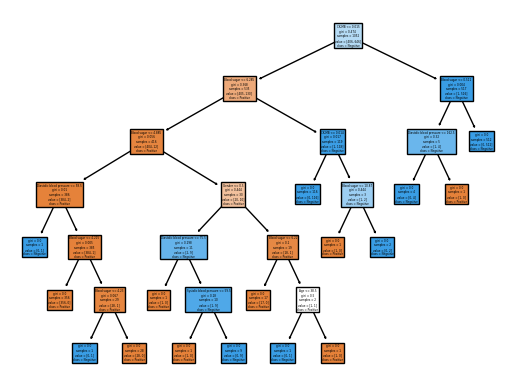

IMPLEMENTATION DE DecisionTreeClassifier()
l'accuracy :
 0.9886
____________________________________________________________________________________________________
le f1 score:
 0.9908
____________________________________________________________________________________________________
la matrice de confusion



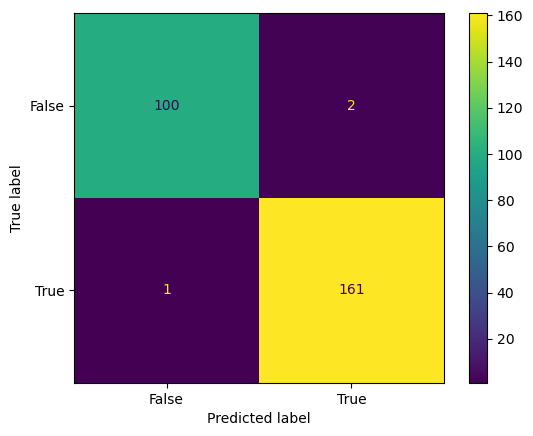

____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       102
           1       0.99      0.99      0.99       162

    accuracy                           0.99       264
   macro avg       0.99      0.99      0.99       264
weighted avg       0.99      0.99      0.99       264

____________________________________________________________________________________________________


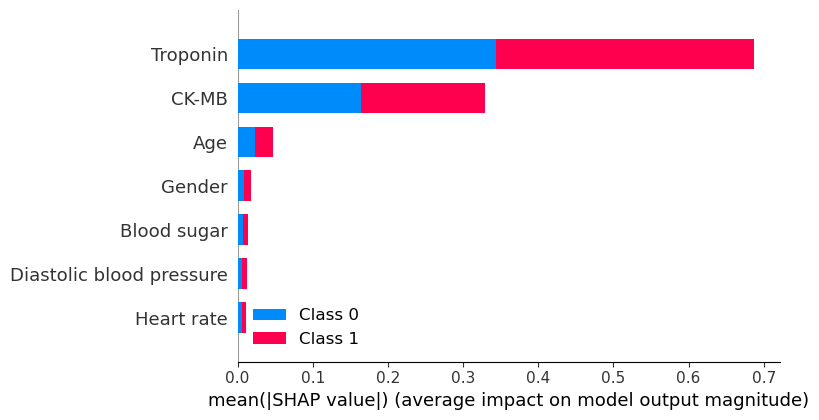

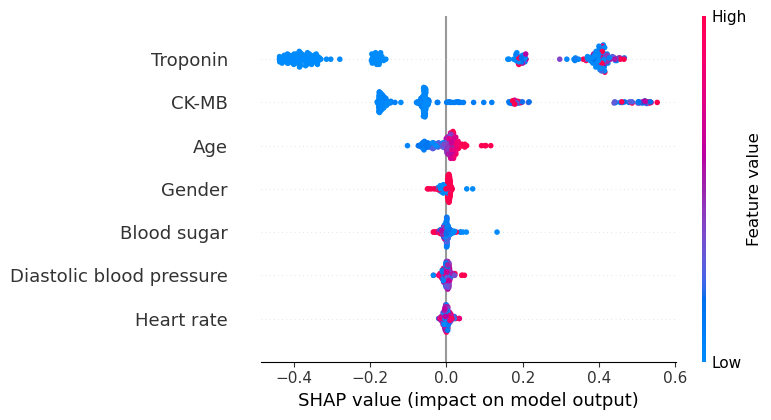

IMPLEMENTATION DE RandomForestClassifier()
l'accuracy :
 0.9848
____________________________________________________________________________________________________
le f1 score:
 0.9877
____________________________________________________________________________________________________
la matrice de confusion



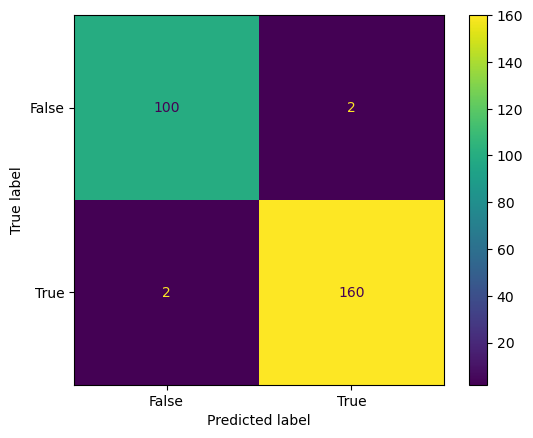

____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       102
           1       0.99      0.99      0.99       162

    accuracy                           0.98       264
   macro avg       0.98      0.98      0.98       264
weighted avg       0.98      0.98      0.98       264

____________________________________________________________________________________________________
IMPLEMENTATION DE AdaBoostClassifier()
l'accuracy :
 0.9848
____________________________________________________________________________________________________
le f1 score:
 0.9877
____________________________________________________________________________________________________
la matrice de confusion



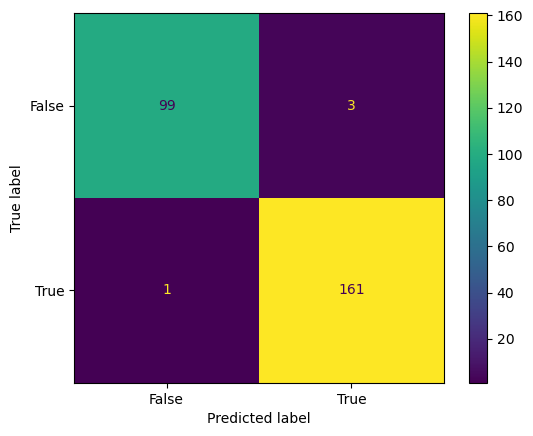

____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       102
           1       0.98      0.99      0.99       162

    accuracy                           0.98       264
   macro avg       0.99      0.98      0.98       264
weighted avg       0.98      0.98      0.98       264

____________________________________________________________________________________________________
      Age  CK-MB
535    55  22.91
769    49   2.34
1187   73   1.44
396    50   5.39
613    69  33.87
...   ...    ...
1197   31   2.85
174    45  16.08
1134   70   2.56
455    63   7.52
703    48   3.47

[1052 rows x 2 columns]


NameError: name 'DecisionBoundaryDisplay' is not defined

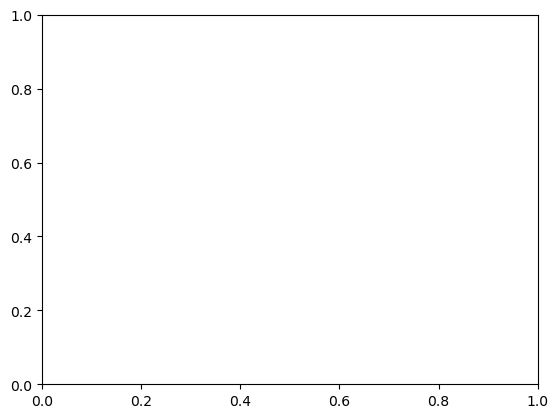

In [134]:
acc_sup2 = []
f1_sup2 = []
recall_sup2 = []

for m in mdl_sup:
    y_pred = implemantation_supervise(m, x_train2, y_train2, x_test2)
    acc, f1,recall = scoring(y_pred, y_test2)
    acc_sup2.append(acc)
    f1_sup2.append(f1)
    recall_sup2.append(recall)
    

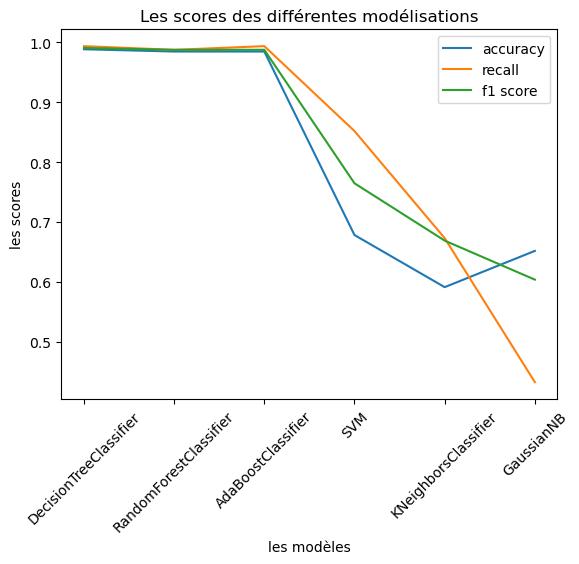

In [117]:
#Afficher la liste des scores dans une courbe
#print(score_list)
mdl_ls = ["DecisionTreeClassifier", "RandomForestClassifier","AdaBoostClassifier", "SVM","KNeighborsClassifier","GaussianNB"]
# "LinearSVC",
fig, ax = plt.subplots()
ax.set(title="Les scores des différentes modélisations",
           ylabel="les scores",
          xlabel="les modèles")
ax.set_xticklabels(mdl_ls, rotation =45)
ax.plot(mdl_ls,acc_sup2, label="accuracy")
ax.plot(mdl_ls,recall_sup2, label="recall")
ax.plot(mdl_ls,f1_sup2, label="f1 score")
plt.legend()

In [118]:
best_model = mdl_sup[(np.argmax(f1_sup))]
print( "les modèle avect les meilleurs performances est le :\n", str(best_model))


les modèle avect les meilleurs performances est le :
 DecisionTreeClassifier()


# Amélioration

On prend les 3 meilleurs modèles puisqu'il n'y a pas de grande différence au niveau des performances et on essaye d'améliorer les résultats avec :

* en ajustant des hyperparamètres
* équilibrer les données

Mais les modèles sont déjà très performant donc il n'y aura pas de réel amélioration

In [144]:
from sklearn.model_selection import GridSearchCV
import imblearn
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
x_train_res, y_train_res = ros.fit_resample(x_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train_res))

Resampled dataset shape Counter({1: 357, 0: 357})


In [168]:
mdl_ls_3 = ["DecisionTreeClassifier", "RandomForestClassifier","AdaBoostClassifier"]

parametres_dt ={'criterion' : ('gini', 'entropy', 'log_loss'),
               'splitter' : ("best", "random"),
               'class_weight' : ("balanced", "None")}
clfdt = GridSearchCV(DecisionTreeClassifier(), parametres_dt)
clfdt.fit(x_train_res, y_train_res)
print(clfdt.best_score_)
print(clfdt.best_params_)


parametres_rd ={ 'criterion' : ('gini', 'entropy', 'log_loss'),
                'bootstrap' : ('True', 'False'),
               'class_weight' : ("balanced", "None","balanced_subsample")}
clfrd = GridSearchCV(RandomForestClassifier(), parametres_rd )
clfrd.fit(x_train_res, y_train_res)
print(clfrd.best_score_)
print(clfrd.best_params_)

parametres_ab ={'algorithm': ('SAMME', 'SAMME.R'),
               'learning_rate':(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0)}
clfab = GridSearchCV(AdaBoostClassifier(), parametres_ab)
clfab.fit(x_train_res, y_train_res)
print(clfab.best_score_)
print(clfab.best_params_)

0.9860041367083621
{'class_weight': 'balanced', 'criterion': 'gini', 'splitter': 'best'}
0.9888111888111888
{'bootstrap': 'True', 'class_weight': 'balanced', 'criterion': 'gini'}
0.9860041367083621
{'algorithm': 'SAMME.R', 'learning_rate': 0.2}


# Application modèles non supervisés

In [15]:
data_clean_unlabeled = data_clean.drop("Result", axis=1)
data_clean_unlabeled

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin
0,64,1,66,160,83,160.0,1.80,0.012
2,55,1,64,160,77,270.0,1.99,0.003
5,58,0,61,112,58,87.0,1.83,0.004
6,32,0,40,179,68,102.0,0.71,0.003
8,44,0,60,154,81,135.0,2.35,0.004
...,...,...,...,...,...,...,...,...
1311,85,1,112,115,69,114.0,2.19,0.062
1312,48,1,84,118,68,96.0,5.33,0.006
1313,86,0,40,179,68,147.0,5.22,0.011
1314,44,1,94,122,67,204.0,1.63,0.006


## Kmeans

Visualiser le résultat  
Metriques  
Itérer pour trouver le nombre max de clusters  
EXPLIMER LIMITE CLUSTERING AGGLOMERATIF AVEC UN EXEMPLE DE JEU DE DONNEES

In [64]:
kmeans = KMeans(n_clusters = 2, random_state=47, n_init="auto").fit(data_clean_unlabeled)
kmeans.cluster_centers_

array([[5.59067358e+01, 6.26943005e-01, 7.55025907e+01, 1.26367876e+02,
        7.29430052e+01, 2.03444041e+02, 2.89075648e+00, 2.08808290e-02],
       [5.55075630e+01, 6.23529412e-01, 7.48285714e+01, 1.25413445e+02,
        7.14857143e+01, 1.06485714e+02, 3.18720672e+00, 2.24672269e-02]])

Comparaison avec le vrai dataset

In [65]:
print((kmeans.labels_ == data_clean['Result']).value_counts())
#L'algorithme ne prédit pas vraiment bien les classes par rapport à ce que l'on s'attend d'obtenir

False    409
True     379
Name: Result, dtype: int64


ACP Réduction en 2 ou 3 dimension pour visualisation

In [66]:
#PCA pour 3 composantes, pas très performant
pca = PCA(n_components = 3).fit(data_clean_unlabeled)
pca.explained_variance_ratio_

array([0.6747394 , 0.18386569, 0.05906749])

In [67]:
#PCA pour 2 composantes
pca = PCA(n_components = 2).fit(data_clean_unlabeled)
pca.explained_variance_ratio_

array([0.6747394 , 0.18386569])

Text(0.5, 1.0, 'Répartition du clustering par ACP')

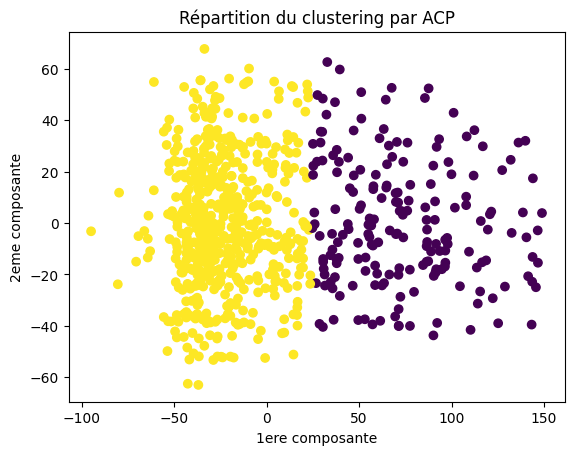

In [68]:
data_clean_pca = pca.transform(data_clean_unlabeled)
plt.scatter(data_clean_pca[:,0],data_clean_pca[:,1], c=kmeans.labels_)
plt.xlabel("1ere composante")
plt.ylabel("2eme composante")
plt.title("Répartition du clustering par ACP")

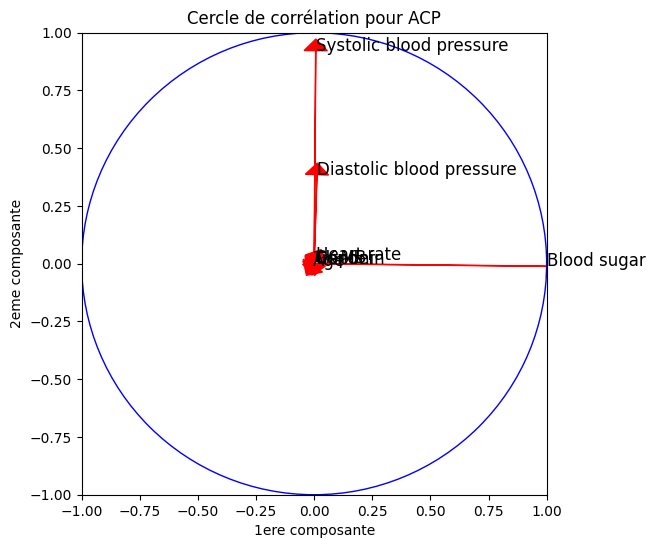

In [69]:
pcs = pca.components_

# Longueur des variables sur les composantes principales
sqrt_eigenvalues = np.sqrt(pca.explained_variance_)

# Initialiser la figure
fig, ax = plt.subplots(figsize = (6,6))

# Tracer les axes des composantes principales
for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    ax.arrow(0, 0, x, y, head_width=0.1, head_length=0.05, fc='r', ec='r')
    ax.text(x, y, data_clean_unlabeled.columns[i], fontsize='12')

# Ajouter un cercle
circle = plt.Circle((0,0), 1, color='b', fill=False)
ax.add_artist(circle)

# Définir les limites des axes
plt.xlim([-1, 1])
plt.ylim([-1, 1])

# Label et titre
plt.xlabel("1ere composante")
plt.ylabel("2eme composante")
plt.title("Cercle de corrélation pour ACP")

# Afficher
plt.show()

In [82]:
#silhouette score
print("Silhouette score : ",silhouette_score(data_clean_unlabeled,kmeans.fit_predict(data_clean_unlabeled)))# Résultat correct

Silhouette score :  0.4817195912227879


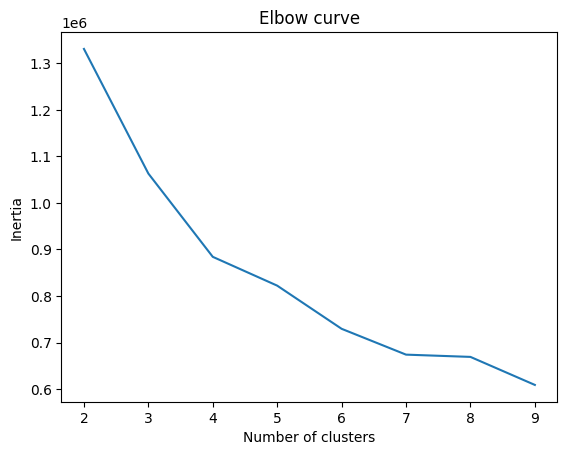

In [22]:
#Elblow method 
inertias = []
for k in range(2,10):
    kmeansElbow = KMeans(n_clusters=k)
    kmeansElbow.fit(data_clean_unlabeled)
    inertias.append(kmeansElbow.inertia_)

plt.plot(range(2,10),inertias)
plt.ylabel("Inertia")
plt.xlabel("Number of clusters")
plt.title("Elbow curve")
plt.show()

## Clustering hiérarchique

Nombre prédef de cluster (2)  
Plot dendogram  
metrics  
nombre optimal de cluster (useless)  
expliquer limite

In [76]:
hierarchClustering = AgglomerativeClustering(n_clusters=2).fit(data_clean_unlabeled)

In [77]:
hierarchClustering.labels_

array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [78]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

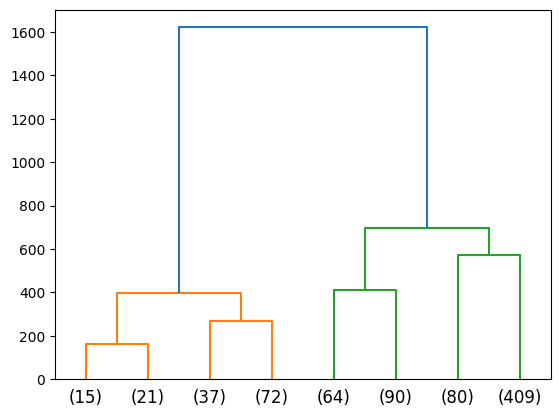

In [79]:
hierarchClustering2 = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(data_clean_unlabeled)
plot_dendrogram(hierarchClustering2,truncate_mode="level",p=2)

In [81]:
#Silhouette
print("Silhouette score : ",silhouette_score(data_clean_unlabeled,hierarchClustering.fit_predict(data_clean_unlabeled)))

Silhouette score :  0.4971603533204936


In [114]:
#test pour 4 clusters
hierarchClustering4Clusters = AgglomerativeClustering(n_clusters=4).fit(data_clean_unlabeled)
print("Silhouette score : ", silhouette_score(data_clean_unlabeled,hierarchClustering4Clusters.fit_predict(data_clean_unlabeled)))

Silhouette score :  0.2287140498004834


## DBSCAN

Exec avec random params  
Visualiser le résultat (ACP)  
metrics  
itérer pour trouver bon hyperparams(time calcul)  
limites

In [105]:
dbscanModel = DBSCAN(eps =25, min_samples=40).fit(data_clean_unlabeled)

In [106]:
dbscanModel.labels_

array([-1, -1,  0, -1,  0,  0,  0, -1,  0,  0,  0, -1,  0,  0,  0,  0,  0,
        0,  0,  0,  0, -1,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,
        0,  0,  0, -1,  0, -1, -1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,
       -1, -1, -1, -1,  0,  0, -1,  0,  0,  0, -1,  0, -1,  0,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
        0,  0,  0, -1, -1, -1, -1,  0,  0, -1,  0,  0,  0, -1,  0,  0, -1,
       -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,
        0, -1,  0,  0, -1,  0,  0,  0, -1,  0,  0,  0,  0,  0, -1,  0, -1,
       -1,  0, -1, -1,  0,  0,  0, -1, -1,  0, -1,  0,  0,  0, -1,  0,  0,
       -1,  0,  0,  0, -1,  0, -1,  0,  0, -1,  0,  0, -1, -1,  0,  0,  0,
       -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0, -1, -1,  0,  0,  0,
        0,  0, -1, -1,  0,  0, -1, -1, -1,  0,  0,  0,  0,  0, -1,  0,  0,
        0,  0, -1,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,
        0, -1,  0, -1,  0

Text(0.5, 1.0, 'Répartition du clustering par ACP')

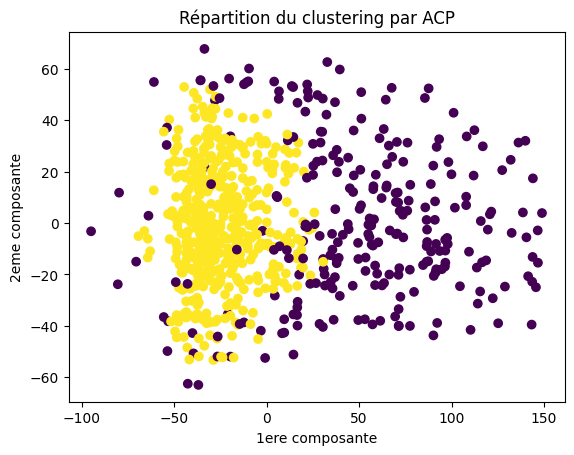

In [107]:
plt.scatter(data_clean_pca[:,0],data_clean_pca[:,1], c=dbscanModel.labels_)
plt.xlabel("1ere composante")
plt.ylabel("2eme composante")
plt.title("Répartition du clustering par ACP")

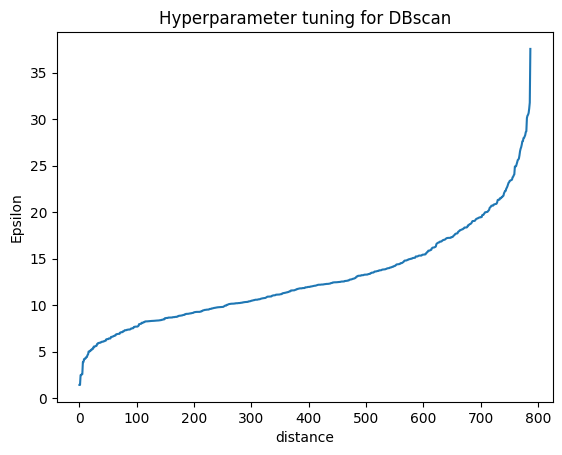

In [94]:
from sklearn.neighbors import NearestNeighbors

neigh=NearestNeighbors(n_neighbors=2)
distance=neigh.fit(data_clean_unlabeled)
distances,indices=distance.kneighbors(data_clean_unlabeled)
sorting_distances=np.sort(distances,axis=0)
sorting_distances=sorting_distances[:,1]

plt.plot(sorting_distances)
plt.xlabel('distance')
plt.ylabel('Epsilon')
plt.title("Hyperparameter tuning for DBscan")
plt.show()

#EPS = 25 looks great

23


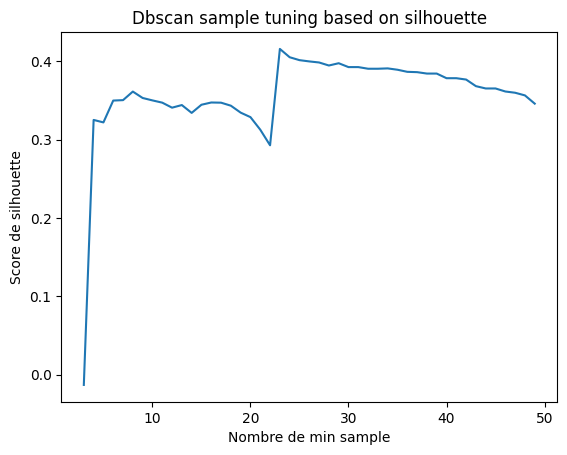

In [111]:
#silhouette score
yAxisSilhouette = []
for sample in range(3,50):
    dbscanModelkSample = DBSCAN(eps =25, min_samples=sample).fit(data_clean_unlabeled)
    yAxisSilhouette.append(silhouette_score(data_clean_unlabeled,dbscanModelkSample.fit_predict(data_clean_unlabeled)))
plt.plot(range(3,50),yAxisSilhouette)
plt.title("Dbscan sample tuning based on silhouette")
plt.xlabel("Nombre de min sample")
plt.ylabel("Score de silhouette")

print(np.argmax(yAxisSilhouette)+3)

In [112]:
dbscanModel = DBSCAN(eps =25, min_samples=23).fit(data_clean_unlabeled)

Text(0.5, 1.0, 'Répartition du clustering par ACP')

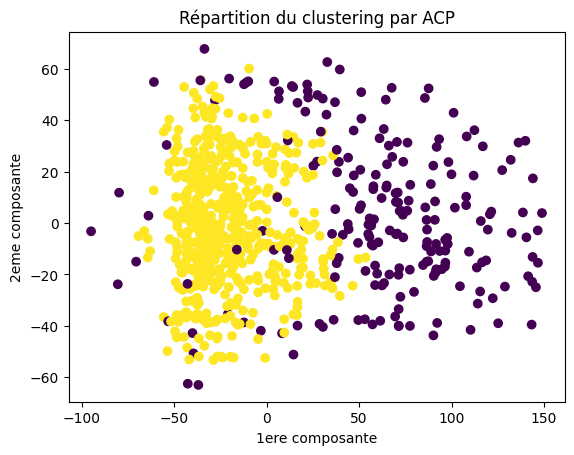

In [113]:
plt.scatter(data_clean_pca[:,0],data_clean_pca[:,1], c=dbscanModel.labels_)
plt.xlabel("1ere composante")
plt.ylabel("2eme composante")
plt.title("Répartition du clustering par ACP")

In [118]:
print("Silhouette score : ", silhouette_score(data_clean_unlabeled,dbscanModel.fit_predict(data_clean_unlabeled)))

Silhouette score :  0.4159410167010197


## HDBSCAN

Exec avec random params  
Visualiser le résultat (ACP)  
metrics  
itérer pour trouver bon hyperparams(time calcul)  
limites

In [30]:
hdbscanModel = HDBSCAN(min_cluster_size=15, cluster_selection_method="eom").fit(data_clean_unlabeled)

In [31]:
hdbscanModel.labels_

array([-1, -1,  0, -1, -1,  0,  0, -1,  0,  0,  0, -1,  0,  0,  0,  0,  0,
        0, -1,  0,  0, -1, -1,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,
        0,  0,  0, -1,  0, -1, -1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,
       -1, -1, -1, -1,  0,  0, -1, -1,  0,  0, -1,  0,  0,  0,  0,  0, -1,
       -1,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0, -1,
        0,  0,  0, -1, -1, -1, -1,  0,  0, -1,  0,  0,  0, -1,  0,  0, -1,
       -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,
        0,  1,  0, -1, -1,  0,  0,  0, -1, -1,  0,  0,  0,  0, -1,  0, -1,
       -1,  0, -1, -1,  0,  0,  0, -1,  0,  0,  1,  0,  0, -1, -1,  0,  0,
        1,  0,  0, -1, -1,  0, -1,  0,  0, -1,  0,  0, -1, -1,  0,  0,  0,
       -1,  0,  0,  0,  0, -1,  0,  0,  0, -1, -1,  0, -1, -1, -1,  0,  0,
        0,  0, -1, -1,  0,  0,  0,  1, -1,  0,  0,  0,  0,  0, -1,  0,  0,
        0,  0, -1,  0, -1, -1, -1,  0,  0,  0,  0, -1,  0, -1, -1,  0,  0,
        0, -1, -1, -1,  0

Text(0.5, 1.0, 'Répartition du clustering par ACP')

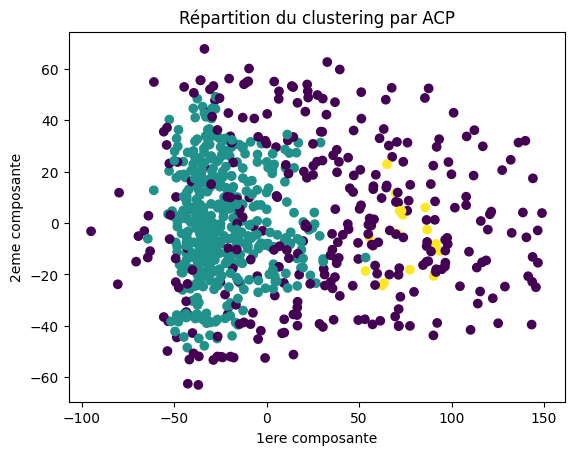

In [32]:
plt.scatter(data_clean_pca[:,0],data_clean_pca[:,1], c=hdbscanModel.labels_)
plt.xlabel("1ere composante")
plt.ylabel("2eme composante")
plt.title("Répartition du clustering par ACP")

In [84]:
#silhouette score
print("Silhouette score : ",silhouette_score(data_clean_unlabeled,hdbscanModel.fit_predict(data_clean_unlabeled)))

Silhouette score :  0.13806663740738973


Need to fix the number of cluster to 2  
And tuning for other hyperparams